In [1]:
from matplotlib import pyplot as plt
from scipy import signal
import numpy as np
import random

In [2]:
%matplotlib inline

In [3]:
shape = (20,20)

# Implement game logic

In [38]:
class Gomoku:
    
    def __init__(self, shape):
        self.shape = shape
        self.reset()
        
    def reset(self):
        self.last_player = 1
        self.board = np.stack((np.zeros(self.shape), np.zeros(self.shape),np.ones(self.shape)), axis=2)
        self.previous_board = np.copy(self.board)
    
    def draw(self):
        plt.imshow(self.board)
    
    def list_actions(self):
        return np.transpose(np.nonzero(self.board[:,:,2])).tolist()
    
    def take_action(self, action):
        self.previous_board = np.copy(self.board)
        self.last_player = 1 - self.last_player 
        pixel = np.zeros((3))
        pixel[self.last_player] = 1
        self.board[action] = pixel
        self.last_action = action
        return self.__revard()
    
    def get_last_action(self):
        return self.last_action
    
    def get_state(self):
        return self.convert_state_for_player(self.board, self.last_player)
    
    def get_raw_state(self):
        return self.board
    
    def get_previous_state(self):
        return self.convert_state_for_player(self.previous_board, self.last_player)
    
    def convert_state_for_player(self, board, player):
        result = np.copy(board)
        
        if player == 1:
            tmp = np.copy(result[:,:,0])
            result[:,:,0] = result[:,:,1]
            result[:,:,1] = tmp
        
        return result

    def game_over(self):
        return self.__won(0) or self.__won(1) or np.count_nonzero(self.board[:,:,2]) == 0
    
    def __revard(self):
        return 1 if self.__won(self.last_player) else 0
        
    def __won(self, player):
        board = self.board[:,:, player]
        return (
            self.__has_five_by(np.identity(5), board) or 
            self.__has_five_by(np.fliplr(np.identity(5)), board) or 
            self.__has_five_by(np.ones((1,5)), board) or 
            self.__has_five_by(np.ones((5,1)), board)
        )
    
    def __has_five_by(self, mask, board):
        return np.count_nonzero(signal.convolve2d(mask, board) == 5) > 0
    
        

In [45]:
game = Gomoku(shape)

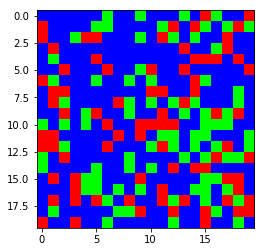

In [6]:
game.reset()
while not game.game_over():
    game.take_action(tuple(random.choice(game.list_actions())))
    
game.draw()

# Deep Q learning

In [32]:
from keras.models import Sequential
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.optimizers import Nadam

from IPython import display

In [104]:
hidden_layer_count = 40

In [105]:
model = Sequential([
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu', input_shape=game.get_state().shape),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(hidden_layer_count, (3,3), padding='same', activation='relu'),
    Conv2D(1, (3,3), padding='same')
])

opt = Nadam(lr=1e-5)
model.compile(optimizer=opt, loss='mean_squared_error')

In [85]:
epsilon = 0.05

In [86]:
def make_move():
    if game.game_over():
        return
    
    if np.random.rand() < epsilon:
        action = tuple(random.choice(game.list_actions()))
    else: 
        q = model.predict(np.expand_dims(game.get_state(), axis=0)).reshape(shape)
        action = tuple(sorted(game.list_actions(), key=lambda x: q[tuple(x)])[-1])
        
    revard = game.take_action(action)

In [94]:
5000game.reset()
while not game.game_over():
    make_move()

    

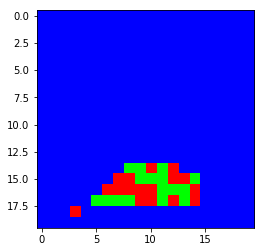

In [95]:
game.draw()

In [114]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 

def state_for_display():
    raw_state = game.get_raw_state()
    last_action = game.get_last_action()
    color_map = model.predict(np.expand_dims(game.get_state(), axis=0)).reshape(shape)
    color_map = color_map - np.min(color_map)
    color_map = (color_map / np.max(color_map) * 255).astype(int)
    
    html = '<table>'
    for i in range(shape[0]):
        html += '<tr>'
        for j in range(shape[1]):
                        
            html += "<td style='border:1px solid gray; width:25px; height:25px; text-align:center; "
            if last_action == (i,j): 
                html += "background-color:rgb(255, "+str(color_map[i,j])+", 0);" 
            else: 
                html += "background-color:rgb(0, "+ str(color_map[i,j]) +", 0);" 
                
            html += "'>"
            if raw_state[i,j,0] == 1:
                html += 'X'
            if raw_state[i,j,1] == 1:
                html += 'O'
            if raw_state[i,j,0] == 1:
                html += '&nbsp;'                
                
            html += "</td>"
        html += '</tr>'

    html += '</table>'
    if game.game_over():
        html += '<h3>Game Over</h3>'
    print(html)

game.reset()



html = """

<div id='display_div'></div>
<button onclick='next()'>&gt;</button>

<script type="text/Javascript">

    function display_state(out) {
        document.getElementById('display_div').innerHTML = out.content.text;
    }

    function next() {
        var kernel = IPython.notebook.kernel;
        kernel.execute('make_move()');
        kernel.execute('state_for_display()', {"iopub" : {"output":display_state}});
    }
    
    next()
</script>
"""

core_display(HTML(html))

In [68]:
floor

NameError: name 'floor' is not defined

In [110]:
result = model.predict(np.expand_dims(game.get_state(), axis=0)).reshape(shape)

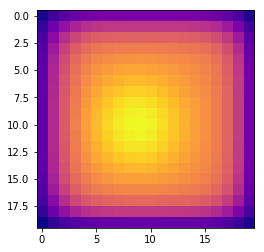

In [111]:
plt.imshow(result, cmap='plasma')

In [89]:
epsilon = 0.05

In [90]:
experiences = []

In [91]:
opt.lr = 1e-5

In [92]:
discount = 0.9

In [113]:
for i in range(10000):
    game.reset()
    game_length = 0
    while not game.game_over():
        if np.random.rand() < epsilon:
            action = tuple(random.choice(game.list_actions()))
        else: 
            q = model.predict(np.expand_dims(game.get_state(), axis=0)).reshape(shape)
            action = tuple(sorted(game.list_actions(), key=lambda x: q[tuple(x)])[-1])

        revard = game.take_action(action)

        experiences.append([game.get_previous_state(), action, revard, game.get_state(), game.game_over()])
        game_length+=1

    experiences[-2][2] = -1
    
    for k in range(3):
        seed_batch = random.sample(experiences, min(2000,len(experiences)))

        original_q = model.predict(np.array([item[0] for item in seed_batch]))
        new_q = model.predict(np.array([item[3] for item in seed_batch]))

        new_q_max = np.squeeze(np.max(np.max(new_q, axis=1), axis=1), axis=1)

        revards = np.array([item[2] for item in seed_batch])
        calculated_q = (revards + discount * new_q_max).tolist()

        desired_q = np.copy(original_q)
        for index in range(len(calculated_q)):
            desired_q[index][seed_batch[index][1]] = calculated_q[index]

        loss = model.train_on_batch(np.array([item[0] for item in seed_batch]), desired_q)
    
    display.clear_output(wait=True)
    print(i, game_length, loss)
    
    if len(experiences) > 30000:
        experiences = random.sample(experiences, 25000)
    

136 41 6.37881e+19


KeyboardInterrupt: 

In [198]:
len(experiences)

21496

In [202]:
experiences = random.sample(experiences, 10000)

In [249]:
experiences[-2]

[array([[[ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         ..., 
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.]],
 
        [[ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         ..., 
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.]],
 
        [[ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         ..., 
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.]],
 
        ..., 
        [[ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         ..., 
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.]],
 
        [[ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         ..., 
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.]],
 
        [[ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         [ 0.,  0.,  1.],
         ..., 
         [ 0.,  0.,  1.